In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
from abnumber import Chain
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import re

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [44]:
SCHEME = 'kabat'
CDR_DEFINITION = 'kabat'
RESIDUES = list('ACDEFGHIKLMNPQRSTVWY')
HIGH_DEAMIDATION_ISOMERIZATION_RISK = list('AHSNGD')
LOW_DEAMIDATION_ISOMERIZATION_RISK = list('PIVLEMWFKCTQRY')

In [3]:
mabs = pd.read_csv('../../data/tasks/humanness/imgt_mab_db.tsv', sep='\t', index_col=0)
mabs = mabs[mabs['Species'].isin(['Human', 'Humanized', 'Humanized/Chimeric', 'Chimeric', 'Mouse'])]
mabs.head()

,Antibody,Species
INN_Number,,
8659,abagovomab,Mouse
10881,abelacimab,Human
9509,abituzumab,Humanized
10745,abrezekimab,Humanized
9921,abrilumab,Human


In [17]:
chains = chains[chains.index.map(lambda seq_id: int(seq_id.split('_')[0]) in mabs.index)]
len(chains)

1102

In [142]:
sites = []
for chain in chains:
    if 'NG' not in chain.seq and 'DG' not in chain.seq:
        continue
    inn = int(chain.name.split('_')[0])
    positions = list(chain.positions)
    imgt_chain = chain.renumber('imgt')
    v_chains, j_chains = imgt_chain.find_human_germlines(1)
    v_chain = v_chains[0]
    j_chain = j_chains[0]
    imgt_positions = list(imgt_chain.positions)
    matches = list(re.finditer('NG', chain.seq)) + list(re.finditer('DG', chain.seq))
    for match in matches:
        if not positions[match.start()].is_in_cdr() or not positions[match.start()+1].is_in_cdr():
            continue
        for n, raw_pos in enumerate([match.start(), match.start() + 1]):
            pos = positions[raw_pos]
            imgt_pos = imgt_positions[raw_pos]
            if imgt_pos in v_chain.positions:
                germline_residue = v_chain[imgt_pos]
            elif imgt_pos in j_chain.positions:
                germline_residue = j_chain[imgt_pos]
            else:
                germline_residue = '-'
            sites.append({
                'motif': chain.seq[match.start():match.start()+2],
                'n': 'N' if n == 0 else f'N+{n}',
                'raw_pos': raw_pos,
                SCHEME+'_pos': str(pos),
                'imgt_pos': str(imgt_pos),
                'in_germline': germline_residue == imgt_chain[imgt_pos],
                'region': pos.get_region(),
                'chain_type': chain.chain_type,
                'inn_number': inn,
                'seq_id': chain.name,
                'germline_gene': v_chain.name,
                'germline_family': v_chain.name.split('-')[0].split('/')[0],
                'antibody': mabs.loc[inn]['Antibody'],
                'species': mabs.loc[inn]['Species'],
                'seq': chain.seq,
            })
sites = pd.DataFrame(sites)
sites.index = 'site' + pd.Series(range(1, len(sites)+1)).astype(str)
sites.head()

,motif,n,raw_pos,kabat_pos,imgt_pos,in_germline,region,chain_type,inn_number,seq_id,germline_gene,germline_family,antibody,species,seq
site1,DG,N,54,H54,H62,False,CDR2,H,8659,8659_seq1,IGHV1-3*01,IGHV1,abagovomab,Mouse,QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLD...
site2,DG,N+1,55,H55,H63,True,CDR2,H,8659,8659_seq1,IGHV1-3*01,IGHV1,abagovomab,Mouse,QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLD...
site3,DG,N,53,H54,H59,False,CDR2,H,10745,10745_seq1,IGHV2-26*01,IGHV2,abrezekimab,Humanized,QVTLKESGPVLVKPTETLTLTCTVSGFSLTNYHVQWIRQPPGKALE...
site4,DG,N+1,54,H55,H63,False,CDR2,H,10745,10745_seq1,IGHV2-26*01,IGHV2,abrezekimab,Humanized,QVTLKESGPVLVKPTETLTLTCTVSGFSLTNYHVQWIRQPPGKALE...
site5,DG,N,97,H95,H107,False,CDR3,H,10745,10745_seq1,IGHV2-26*01,IGHV2,abrezekimab,Humanized,QVTLKESGPVLVKPTETLTLTCTVSGFSLTNYHVQWIRQPPGKALE...


In [143]:
sites['in_germline'].value_counts()

True     324
False    298
Name: in_germline, dtype: int64

In [146]:
sites.groupby('n')['in_germline'].value_counts()

n    in_germline
N    False          197
     True           114
N+1  True           210
     False          101
Name: in_germline, dtype: int64

In [20]:
chains[0].print_wide(numbering=True)

0        1         2         3         4         5          6         7         8            9         10          11  
12345678901234567890123456789012345678901234567890122345678901234567890123456789012222345678901234567890001234567890123
                                                    A                              ABC                  AB             
QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLDWIGAIYPGDGNTRYTHKFKGKATLTADKSSSTAYMQLSSLASEDSGVYYCARGEGNYAWFAYWGQGTTVTVSS
 °                        °°°°^^^^^           °°°^^^^^^^^^^^^^^^^^ ° ° ° °    °                 °°^^^^^^^^^^°          


In [21]:
chains[1].print_wide(numbering=True)

0        1         2         3         4         5         6         7         8         9         10      
12345678901234567890123456789012345678901234567890123456789012345678901234567890123456789012345678901234567
DIELTQSPASLSASVGETVTITCQASENIYSYLAWHQQKQGKSPQLLVYNAKTLAGGVSSRFSGSGSGTHFSLKIKSLQPEDFGIYYCQHHYGILPTFGGGTKLEIK
 ° °                   ^^^^^^^^^^^°°         °°°°^^^^^^^       ° ° °° °                 ^^^^^^^^^°         


In [22]:
sites.groupby('germline_family')[SCHEME+'_pos'].value_counts()

germline_family  kabat_pos
IGHV1            H55          81
                 H54          74
                 H96          12
                 H99          11
                 H98           9
                              ..
IGLV3            L93           1
IGLV6            L92           1
                 L93           1
IGLV8            L94           1
                 L95           1
Name: kabat_pos, Length: 80, dtype: int64

In [23]:
sites.groupby('chain_type')[SCHEME+'_pos'].value_counts()

chain_type  kabat_pos
H           H54          166
            H55          115
            H53           59
            H96           29
            H98           22
            H95           20
            H99           19
            H97           14
            H56            8
            H100           6
            H100A          3
            H100D          3
            H101           3
            H60            3
            H61            3
            H100C          2
            H100E          2
            H102           2
            H100B          1
            H100G          1
            H100H          1
            H32            1
            H33            1
            H52            1
            H52A           1
K           L28           57
            L29           57
            L90            1
            L91            1
            L92            1
            L93            1
L           L95A           4
            L95B           4
            L93      

In [24]:
sites['species'].value_counts()

Humanized             258
Human                 180
Chimeric              106
Humanized/Chimeric     52
Mouse                  26
Name: species, dtype: int64

In [25]:
sites['region'].value_counts()

CDR2    358
CDR3    148
CDR1    116
Name: region, dtype: int64

In [26]:
sites.groupby('motif')['region'].value_counts()

motif  region
DG     CDR2      218
       CDR3      116
       CDR1       38
NG     CDR2      140
       CDR1       78
       CDR3       32
Name: region, dtype: int64

In [144]:
sites.to_csv('../../data/tasks/ptm_mitigation/ptm_sites.tsv', sep='\t', index=True)

In [28]:
with open('../../data/tasks/ptm_mitigation/ptm_seqs_masked.fa','wt') as f:
    site_seqs = []
    for site_id, site in sites.iterrows():
        seq = chains[site['seq_id']].seq
        masked_seq = seq[:site['raw_pos']] + 'X' + seq[site['raw_pos']+1:]
        SeqIO.write(SeqRecord(Seq(masked_seq), id=site_id, description=''), f, 'fasta-2line')

In [29]:
with open('../../data/tasks/ptm_mitigation/ptm_seqs_orig.fa','wt') as f:
    site_seqs = []
    for site_id, site in sites.iterrows():
        seq = chains[site['seq_id']].seq
        SeqIO.write(SeqRecord(Seq(seq), id=site_id, description=''), f, 'fasta-2line')

In [30]:
# generate oasis using
!cd ../../; make data/tasks/ptm_mitigation/ptm_seqs_orig_oasis.xlsx

source $(conda info --base)/bin/activate biophi && biophi oasis \
        data/tasks/ptm_mitigation/ptm_seqs_orig.fa \
        --output data/tasks/ptm_mitigation/ptm_seqs_orig_oasis.xlsx \
        --oas-db sqlite:///../biophi/work/oas_clean_human_subject_9mers_2019_11.db \
        --proteome-db sqlite:///../biophi/work/uniprot_human_proteome_9mers.db
      __     ____  _       ____  _     _      ___    _   ____  _
  /| /  \   | __ )(_) ___ |  _ \| |__ (_)    / _ \  / \ / ___|(_)___
 ( || [] )  |  _ \| |/ _ \| |_) | '_ \| |   | | | |/ _ \\___ \| / __|
  \_   _/   | |_) | | (_) |  __/| | | | |   | |_| / ___ \___| | \__ \
    | |     |____/|_|\___/|_|   |_| |_|_|    \___/_/   \_\___/|_|___/
    |_|                       version 1.0                  version 1.0
────────────────────────────────────────────────────────────────────────

Settings:
- OAS database: sqlite:///../biophi/work/oas_clean_human_subject_9mers_2019_11.db
- Proteome database: sqlite:///../biophi/work/uniprot_human_proteo

In [31]:
# generate sapiens using
!cd ../../; make data/tasks/ptm_mitigation/sapiens

source $(conda info --base)/bin/activate biophi && biophi sapiens \
        data/tasks/ptm_mitigation/ptm_seqs_masked.fa \
        --output data/tasks/ptm_mitigation/sapiens \
        --version 2020_11_01 \
        --service-url http://localhost:5001/predict \
        --oas-db sqlite:///../biophi/work/oas_clean_human_subject_9mers_2019_11.db \
        --proteome-db sqlite:///../biophi/work/uniprot_human_proteome_9mers.db \
        --iterations 1
      __     ____  _       ____  _     _     ____              _                
  /| /  \   | __ )(_) ___ |  _ \| |__ (_)   / ___|  __ _ _ __ (_) ___ _ __  ___ 
 ( || [] )  |  _ \| |/ _ \| |_) | '_ \| |   \___ \ / _` | '_ \| |/ _ \ '_ \/ __|
  \_   _/   | |_) | | (_) |  __/| | | | |    ___| | |_| | |_| | |  __/ | | \__ \
    | |     |____/|_|\___/|_|   |_| |_|_|   |____/ \__,_|  __/|_|\___|_| |_|___/
    |_|                       version 1.0               |_|          version 1.0
────────────────────────────────────────────────────────────────

In [35]:
sapiens_sheets = pd.read_excel('../../data/tasks/ptm_mitigation/sapiens/Sapiens.xlsx', sheet_name=None)

In [36]:
def get_sapiens_score(site):
    scores = sapiens_sheets[site.name][RESIDUES]
    return scores.iloc[site['raw_pos']]

In [37]:
sapiens_scores = sites.apply(get_sapiens_score, axis=1)
sapiens_scores.head()

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
site1,0.006672,0.004062,0.064391,0.006879,0.005101,0.018614,0.013342,0.014122,0.019997,0.004089,0.002860,0.615544,0.003936,0.004129,0.009181,0.109642,0.053904,0.006135,0.004352,0.015939
site2,0.020032,0.011632,0.028465,0.007694,0.005327,0.790025,0.007338,0.004428,0.004318,0.004555,0.004172,0.014924,0.003570,0.005124,0.009788,0.021128,0.008797,0.011855,0.005328,0.011761
site3,0.026422,0.007061,0.293521,0.016706,0.009773,0.029343,0.020120,0.017691,0.046332,0.012545,0.006790,0.233328,0.007495,0.009438,0.038313,0.105840,0.054731,0.014407,0.008205,0.013772
site4,0.032303,0.006715,0.262073,0.059243,0.006819,0.490912,0.007013,0.006205,0.004395,0.005774,0.006096,0.009710,0.005963,0.008257,0.006312,0.021219,0.008076,0.016576,0.006057,0.007632
site5,0.028856,0.005767,0.012394,0.015375,0.010123,0.036711,0.015776,0.250427,0.014950,0.058217,0.107486,0.008615,0.012972,0.010834,0.106693,0.058908,0.163109,0.041723,0.010368,0.005071


In [104]:
melted_sapiens_scores = sapiens_scores.melt(var_name='residue', value_name='score', ignore_index=False)
melted_sapiens_scores['site'] = (sites['motif'] + ' position ' + sites['n']).loc[melted_sapiens_scores.index]
melted_sapiens_scores = melted_sapiens_scores.reset_index()
melted_sapiens_scores.head()

,index,residue,score,site
0,site1,A,0.006672,DG position N
1,site2,A,0.020032,DG position N+1
2,site3,A,0.026422,DG position N
3,site4,A,0.032303,DG position N+1
4,site5,A,0.028856,DG position N


<AxesSubplot:xlabel='residue', ylabel='score'>

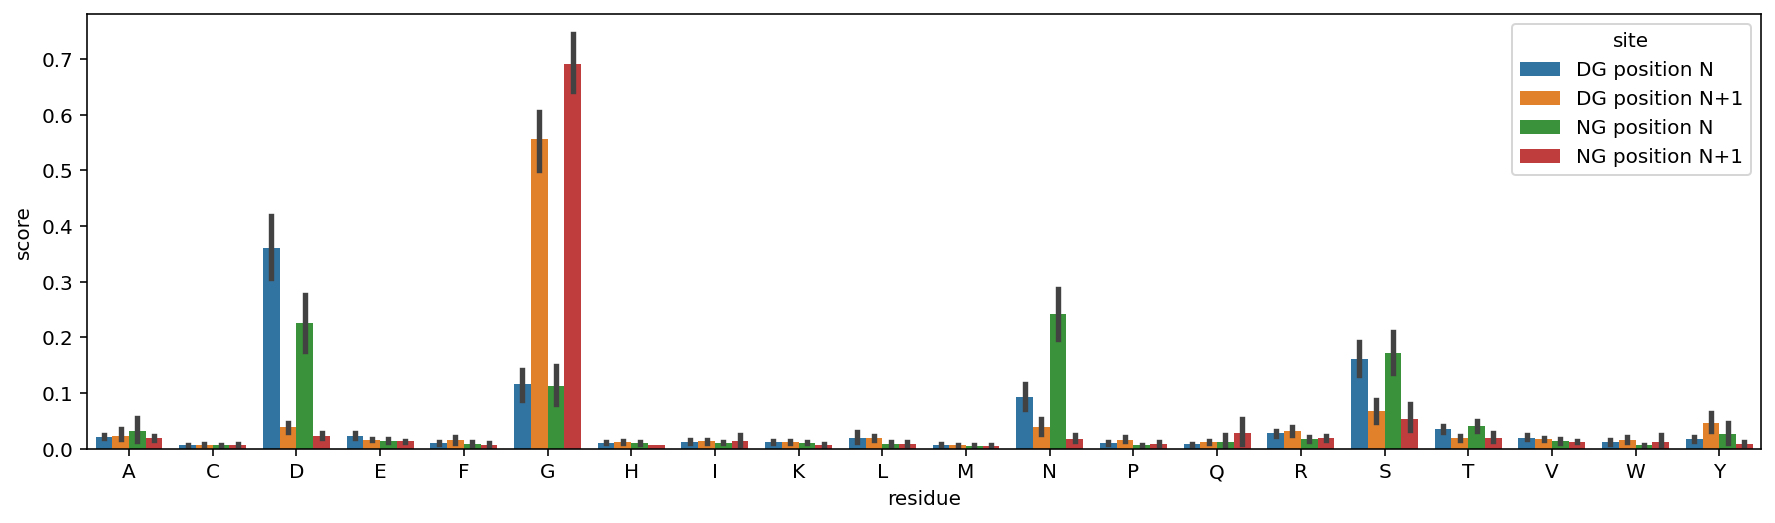

In [105]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.barplot(
    data=melted_sapiens_scores,
    hue='site',
    x='residue',
    y='score',
    ax=ax
)

<AxesSubplot:xlabel='residue', ylabel='score'>

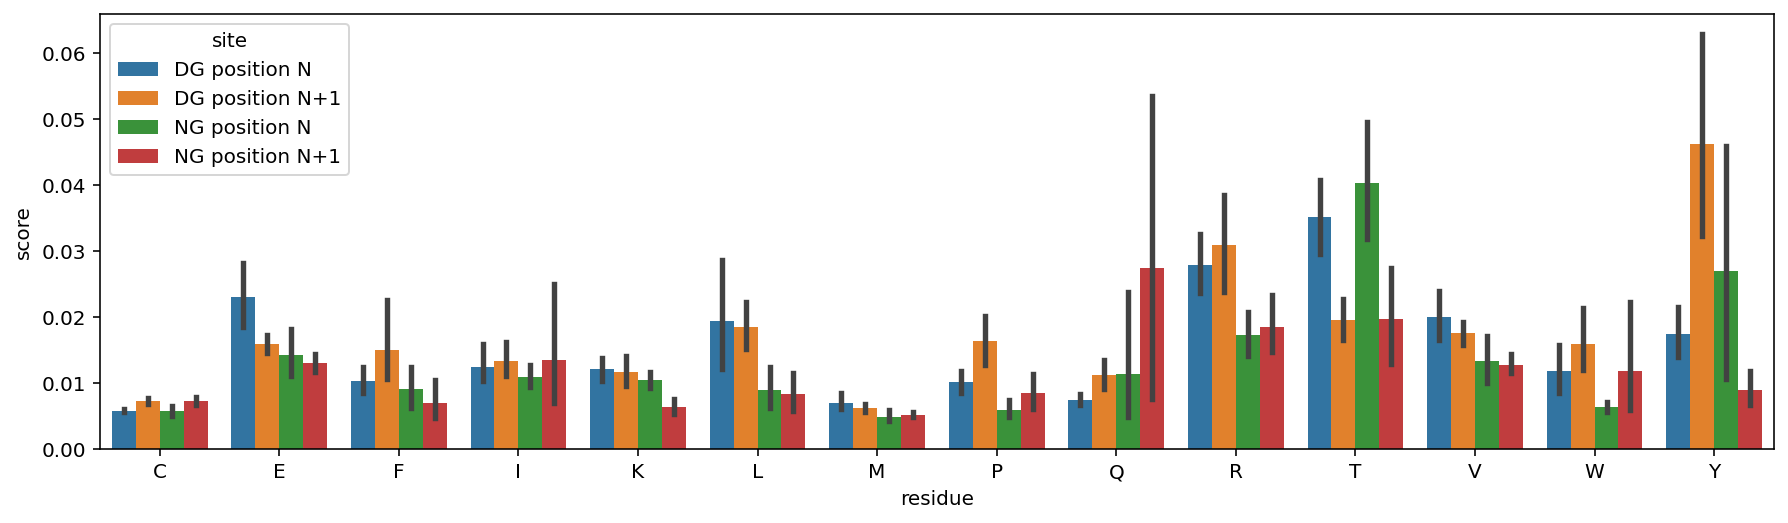

In [106]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.barplot(
    data=melted_sapiens_scores[melted_sapiens_scores['residue'].isin(LOW_DEAMIDATION_ISOMERIZATION_RISK)],
    hue='site',
    x='residue',
    y='score',
    ax=ax
)

In [78]:
sapiens_choice = sapiens_scores[LOW_DEAMIDATION_ISOMERIZATION_RISK].idxmax(axis=1)
sapiens_choice

site1      T
site2      V
site3      T
site4      E
site5      I
          ..
site618    V
site619    T
site620    T
site621    T
site622    V
Length: 622, dtype: object

In [79]:
sapiens_choice.value_counts()

E    201
T    136
V    100
R     86
Y     40
K     17
W      9
L      9
I      9
Q      5
F      4
C      3
P      3
dtype: int64

In [80]:
sapiens_choice.groupby(sites['region']).value_counts()

region   
CDR1    E     64
        T     20
        R     17
        I      7
        K      3
        V      2
        C      1
        Q      1
        Y      1
CDR2    E    118
        T     89
        V     88
        R     32
        K     12
        L      6
        Y      4
        Q      3
        C      2
        F      2
        P      1
        W      1
CDR3    R     37
        Y     35
        T     27
        E     19
        V     10
        W      8
        L      3
        F      2
        I      2
        K      2
        P      2
        Q      1
dtype: int64

In [81]:
def mutate_site(site, choices):
    choice = choices[site.name]
    return site['seq'][:site['raw_pos']] + choice + site['seq'][site['raw_pos']+1:]

## Sapiens mutants

In [82]:
sapiens_mutants = sites.apply(mutate_site, choices=sapiens_choice, axis=1)

print(' '*sites['raw_pos'][0] + '↓')
print(sites['seq'][0])
print(sapiens_mutants[0])

                                                      ↓
QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLDWIGAIYPGDGNTRYTHKFKGKATLTADKSSSTAYMQLSSLASEDSGVYYCARGEGNYAWFAYWGQGTTVTVSS
QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLDWIGAIYPGTGNTRYTHKFKGKATLTADKSSSTAYMQLSSLASEDSGVYYCARGEGNYAWFAYWGQGTTVTVSS


In [83]:
print(' '*sites['raw_pos'][1] + '↓')
print(sites['seq'][1])
print(sapiens_mutants[1])

                                                       ↓
QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLDWIGAIYPGDGNTRYTHKFKGKATLTADKSSSTAYMQLSSLASEDSGVYYCARGEGNYAWFAYWGQGTTVTVSS
QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLDWIGAIYPGDVNTRYTHKFKGKATLTADKSSSTAYMQLSSLASEDSGVYYCARGEGNYAWFAYWGQGTTVTVSS


In [84]:
with open('../../data/tasks/ptm_mitigation/mutants_sapiens.fa', 'w') as f:
    for site_id, seq in sapiens_mutants.items():
        SeqIO.write(SeqRecord(Seq(seq), id=site_id, description=''), f, 'fasta-2line')

In [85]:
!cd ../../; make data/tasks/ptm_mitigation/mutants_sapiens_oasis.xlsx

source $(conda info --base)/bin/activate biophi && biophi oasis \
        data/tasks/ptm_mitigation/mutants_sapiens.fa \
        --output data/tasks/ptm_mitigation/mutants_sapiens_oasis.xlsx \
        --oas-db sqlite:///../biophi/work/oas_clean_human_subject_9mers_2019_11.db \
        --proteome-db sqlite:///../biophi/work/uniprot_human_proteome_9mers.db
      __     ____  _       ____  _     _      ___    _   ____  _
  /| /  \   | __ )(_) ___ |  _ \| |__ (_)    / _ \  / \ / ___|(_)___
 ( || [] )  |  _ \| |/ _ \| |_) | '_ \| |   | | | |/ _ \\___ \| / __|
  \_   _/   | |_) | | (_) |  __/| | | | |   | |_| / ___ \___| | \__ \
    | |     |____/|_|\___/|_|   |_| |_|_|    \___/_/   \_\___/|_|___/
    |_|                       version 1.0                  version 1.0
────────────────────────────────────────────────────────────────────────

Settings:
- OAS database: sqlite:///../biophi/work/oas_clean_human_subject_9mers_2019_11.db
- Proteome database: sqlite:///../biophi/work/uniprot_human_pr

## Frequency mutants

In [100]:
def get_site_germline_frequency(site):
    path = f'../../data/oas_stats/imgt_residue_frequency/{site.germline_family}.tsv'
    if not os.path.exists(path):
        print('Germline not available:', site.name, site.germline_family)
        return np.nan
    stats = pd.read_csv(path, sep='\t', index_col=0)
    stats.index = stats.index.astype(str)
    imgt_pos = site['imgt_pos'].replace('H','').replace('L','')
    if imgt_pos not in stats.index:
        print('Frequency at position not available:', site.name, imgt_pos, site.germline_family)
        return np.nan
    return stats.loc[imgt_pos]

In [101]:
germline_frequency = sites.apply(get_site_germline_frequency, axis=1)
germline_frequency.head()

Germline not available: site69 IGKV7
Germline not available: site70 IGKV7
Frequency at position not available: site75 34 IGKV3
Frequency at position not available: site76 35 IGKV3
Frequency at position not available: site95 34 IGKV1
Frequency at position not available: site96 35 IGKV1
Frequency at position not available: site107 34 IGKV1
Frequency at position not available: site108 35 IGKV1
Frequency at position not available: site115 34 IGKV1
Frequency at position not available: site116 35 IGKV1
Frequency at position not available: site205 34 IGKV1
Frequency at position not available: site206 35 IGKV1
Frequency at position not available: site353 34 IGKV1
Frequency at position not available: site354 35 IGKV1
Frequency at position not available: site359 34 IGKV3
Frequency at position not available: site360 35 IGKV3
Frequency at position not available: site379 34 IGKV1
Frequency at position not available: site380 35 IGKV1
Frequency at position not available: site459 34 IGKV1
Frequency at

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
site1,0.0022,0.0045,0.0604,0.0031,0.2144,0.0886,0.0047,0.0060,0.0060,0.0799,0.0008,0.2213,0.0014,0.0006,0.0122,0.2585,0.0210,0.0097,0.0002,0.0045
site2,0.0087,0.0045,0.0215,0.0037,0.0002,0.9298,0.0013,0.0005,0.0008,0.0006,0.0000,0.0069,0.0008,0.0005,0.0047,0.0073,0.0017,0.0051,0.0003,0.0011
site3,0.0041,0.0001,0.5605,0.0060,0.0001,0.0054,0.0053,0.0014,0.0038,0.0001,0.0001,0.3951,0.0000,0.0004,0.0005,0.0068,0.0054,0.0013,0.0000,0.0034
site4,0.0074,0.0011,0.9259,0.0100,0.0001,0.0311,0.0012,0.0000,0.0002,0.0000,0.0001,0.0142,0.0000,0.0000,0.0001,0.0010,0.0001,0.0025,0.0000,0.0049
site5,0.0311,0.0049,0.0103,0.0117,0.0129,0.0405,0.0082,0.1911,0.0208,0.0381,0.0441,0.0167,0.0065,0.0086,0.2337,0.1756,0.0998,0.0277,0.0049,0.0127


In [102]:
melted_germline_frequency = germline_frequency.melt(var_name='residue', value_name='frequency', ignore_index=False)
melted_germline_frequency['site'] = (sites['motif'] + ' position ' + sites['n']).loc[melted_germline_frequency.index]
melted_germline_frequency = melted_germline_frequency.reset_index()
melted_germline_frequency.head()

,index,residue,frequency,site
0,site1,A,0.0022,DG position N
1,site2,A,0.0087,DG position N+1
2,site3,A,0.0041,DG position N
3,site4,A,0.0074,DG position N+1
4,site5,A,0.0311,DG position N


<AxesSubplot:xlabel='residue', ylabel='frequency'>

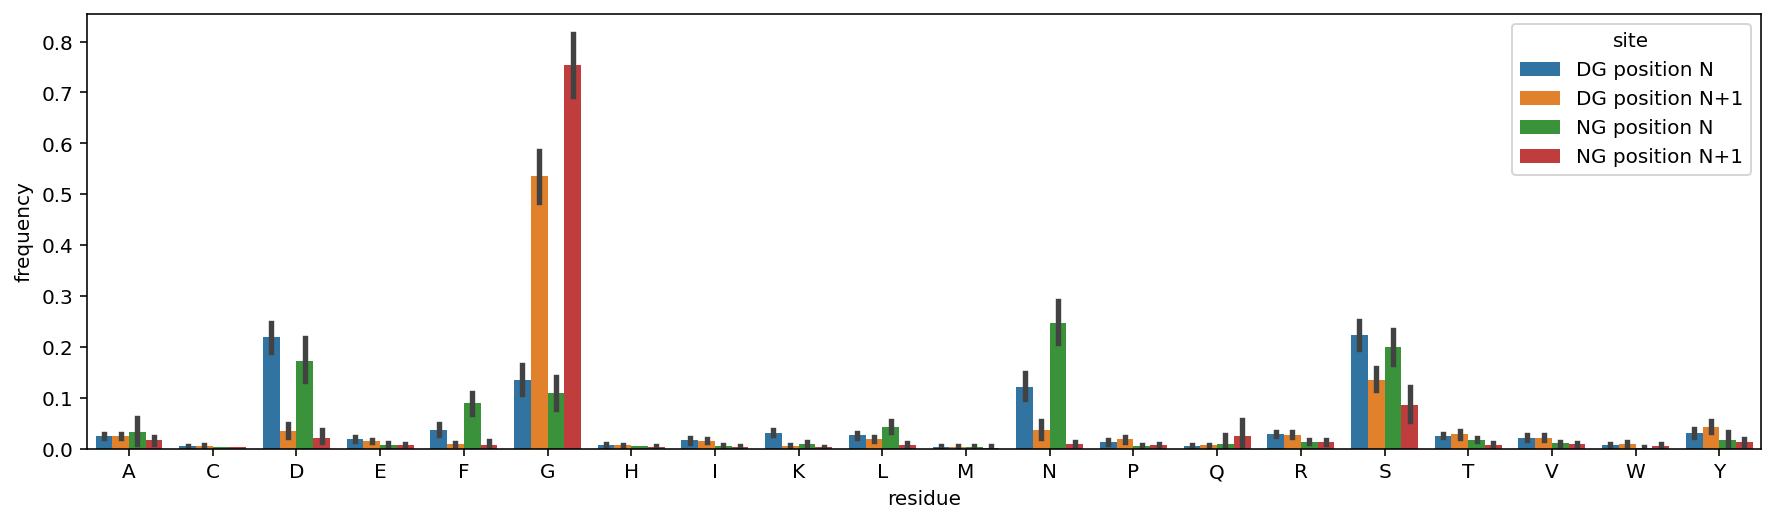

In [107]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.barplot(
    data=melted_germline_frequency,
    hue='site',
    x='residue',
    y='frequency',
    ax=ax
)

<AxesSubplot:xlabel='residue', ylabel='frequency'>

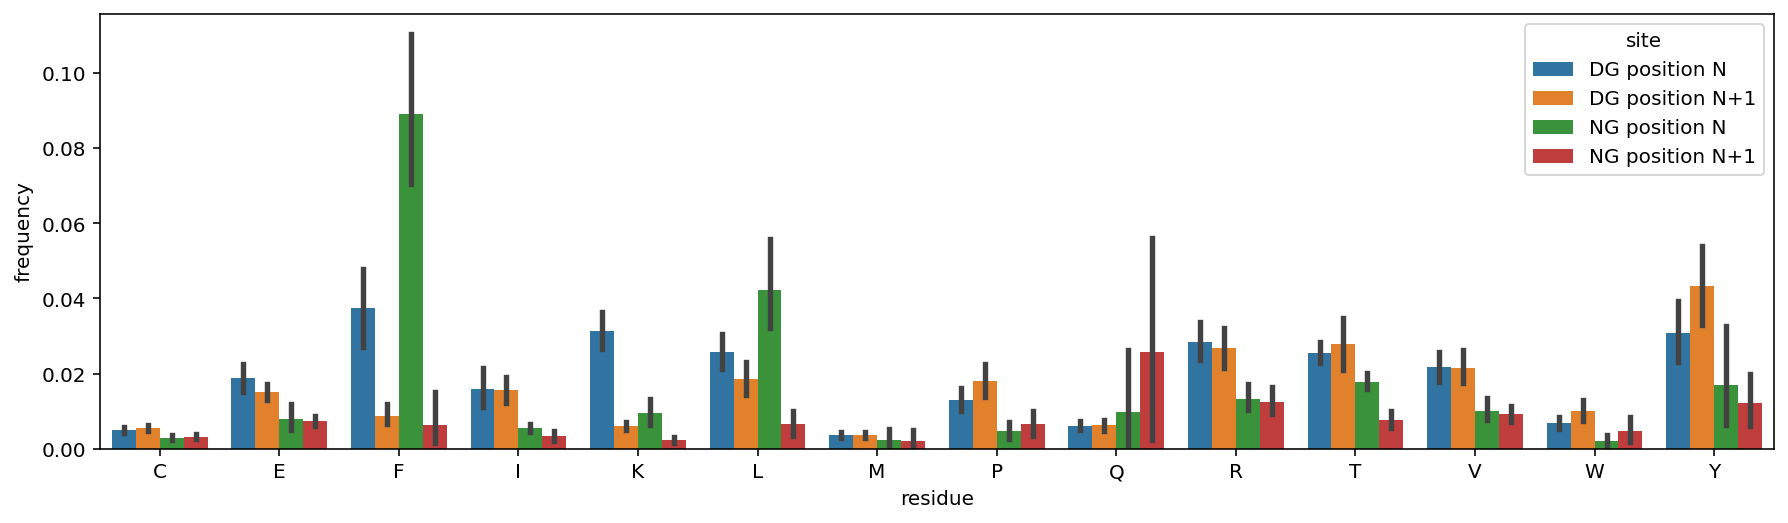

In [108]:
fig, ax = plt.subplots(figsize=(15, 4))
sns.barplot(
    data=melted_germline_frequency[melted_germline_frequency['residue'].isin(LOW_DEAMIDATION_ISOMERIZATION_RISK)],
    hue='site',
    x='residue',
    y='frequency',
    ax=ax
)

In [109]:
frequency_choice = germline_frequency[LOW_DEAMIDATION_ISOMERIZATION_RISK].idxmax(axis=1)
frequency_choice

site1      F
site2      V
site3      E
site4      E
site5      R
          ..
site618    V
site619    I
site620    F
site621    F
site622    V
Length: 622, dtype: object

In [112]:
frequency_choice.value_counts()

E    113
V     88
Y     88
T     80
F     75
K     68
R     67
L      8
Q      4
I      3
W      1
P      1
dtype: int64

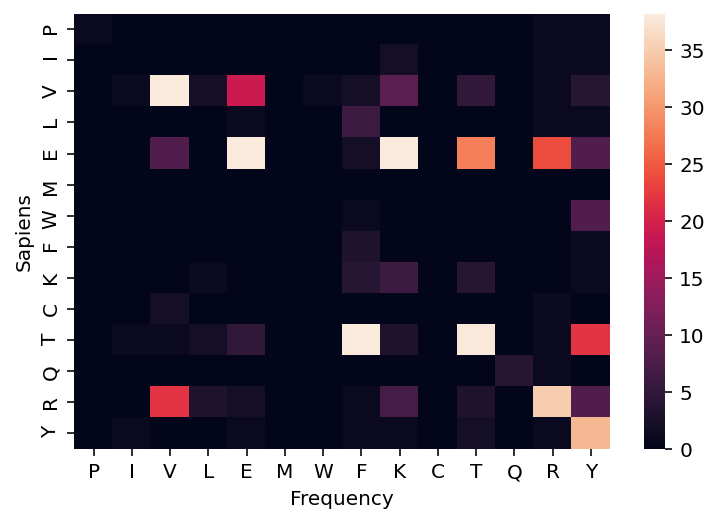

In [124]:
agreement = pd.DataFrame({
    'Sapiens': sapiens_choice,
    'Frequency': frequency_choice
}).groupby(['Sapiens','Frequency']).size().unstack().reindex(LOW_DEAMIDATION_ISOMERIZATION_RISK).reindex(LOW_DEAMIDATION_ISOMERIZATION_RISK, axis=1)
agreement = agreement.fillna(0).astype(int)

ax = sns.heatmap(agreement, robust=True);

In [128]:
frequency_mutants = sites[~frequency_choice.isna()].apply(mutate_site, choices=frequency_choice, axis=1)

print(' '*sites['raw_pos'][0] + '↓')
print(sites['seq'][0])
print(frequency_mutants[0])

                                                      ↓
QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLDWIGAIYPGDGNTRYTHKFKGKATLTADKSSSTAYMQLSSLASEDSGVYYCARGEGNYAWFAYWGQGTTVTVSS
QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLDWIGAIYPGFGNTRYTHKFKGKATLTADKSSSTAYMQLSSLASEDSGVYYCARGEGNYAWFAYWGQGTTVTVSS


In [129]:
print(' '*sites['raw_pos'][1] + '↓')
print(sites['seq'][1])
print(frequency_mutants[1])

                                                       ↓
QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLDWIGAIYPGDGNTRYTHKFKGKATLTADKSSSTAYMQLSSLASEDSGVYYCARGEGNYAWFAYWGQGTTVTVSS
QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLDWIGAIYPGDVNTRYTHKFKGKATLTADKSSSTAYMQLSSLASEDSGVYYCARGEGNYAWFAYWGQGTTVTVSS


In [130]:
with open('../../data/tasks/ptm_mitigation/mutants_frequency.fa', 'w') as f:
    for site_id, seq in frequency_mutants.items():
        SeqIO.write(SeqRecord(Seq(seq), id=site_id, description=''), f, 'fasta-2line')

In [131]:
!cd ../../; make data/tasks/ptm_mitigation/mutants_frequency_oasis.xlsx

source $(conda info --base)/bin/activate biophi && biophi oasis \
        data/tasks/ptm_mitigation/mutants_frequency.fa \
        --output data/tasks/ptm_mitigation/mutants_frequency_oasis.xlsx \
        --oas-db sqlite:///../biophi/work/oas_clean_human_subject_9mers_2019_11.db \
        --proteome-db sqlite:///../biophi/work/uniprot_human_proteome_9mers.db
      __     ____  _       ____  _     _      ___    _   ____  _
  /| /  \   | __ )(_) ___ |  _ \| |__ (_)    / _ \  / \ / ___|(_)___
 ( || [] )  |  _ \| |/ _ \| |_) | '_ \| |   | | | |/ _ \\___ \| / __|
  \_   _/   | |_) | | (_) |  __/| | | | |   | |_| / ___ \___| | \__ \
    | |     |____/|_|\___/|_|   |_| |_|_|    \___/_/   \_\___/|_|___/
    |_|                       version 1.0                  version 1.0
────────────────────────────────────────────────────────────────────────

Settings:
- OAS database: sqlite:///../biophi/work/oas_clean_human_subject_9mers_2019_11.db
- Proteome database: sqlite:///../biophi/work/uniprot_huma

## Random mutants

In [136]:
np.random.seed(0)
random_choice = sites.apply(lambda row: LOW_DEAMIDATION_ISOMERIZATION_RISK[np.random.randint(len(LOW_DEAMIDATION_ISOMERIZATION_RISK))], axis=1)
random_choice.head()

site1    R
site2    M
site3    P
site4    L
site5    Q
dtype: object

In [137]:
random_mutants = sites.apply(mutate_site, choices=random_choice, axis=1)

print(' '*sites['raw_pos'][0] + '↓↓')
print(sites['seq'][0])
print(random_mutants[0])

                                                      ↓↓
QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLDWIGAIYPGDGNTRYTHKFKGKATLTADKSSSTAYMQLSSLASEDSGVYYCARGEGNYAWFAYWGQGTTVTVSS
QVKLQESGAELARPGASVKLSCKASGYTFTNYWMQWVKQRPGQGLDWIGAIYPGRGNTRYTHKFKGKATLTADKSSSTAYMQLSSLASEDSGVYYCARGEGNYAWFAYWGQGTTVTVSS


In [138]:
with open('../../data/tasks/ptm_mitigation/mutants_random.fa', 'w') as f:
    for site_id, seq in random_mutants.items():
        SeqIO.write(SeqRecord(Seq(seq), id=site_id, description=''), f, 'fasta-2line')

In [145]:
!cd ../../; make data/tasks/ptm_mitigation/mutants_random_oasis.xlsx

source $(conda info --base)/bin/activate biophi && biophi oasis \
        data/tasks/ptm_mitigation/mutants_random.fa \
        --output data/tasks/ptm_mitigation/mutants_random_oasis.xlsx \
        --oas-db sqlite:///../biophi/work/oas_clean_human_subject_9mers_2019_11.db \
        --proteome-db sqlite:///../biophi/work/uniprot_human_proteome_9mers.db
      __     ____  _       ____  _     _      ___    _   ____  _
  /| /  \   | __ )(_) ___ |  _ \| |__ (_)    / _ \  / \ / ___|(_)___
 ( || [] )  |  _ \| |/ _ \| |_) | '_ \| |   | | | |/ _ \\___ \| / __|
  \_   _/   | |_) | | (_) |  __/| | | | |   | |_| / ___ \___| | \__ \
    | |     |____/|_|\___/|_|   |_| |_|_|    \___/_/   \_\___/|_|___/
    |_|                       version 1.0                  version 1.0
────────────────────────────────────────────────────────────────────────

Settings:
- OAS database: sqlite:///../biophi/work/oas_clean_human_subject_9mers_2019_11.db
- Proteome database: sqlite:///../biophi/work/uniprot_human_prot